https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html

In [ ]:
import torch.nn as nn
import torch

class VGG_16_v6(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 4
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Block 5
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
from tqdm.notebook import tqdm
import torch
import numpy as np

# --- add this helper once (top-level) ---
import torch.nn.functional as F

# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

def soft_cross_entropy(logits, soft_targets):
    # logits: (B, C) ; soft_targets: (B, C)
    log_probs = F.log_softmax(logits, dim=-1)
    return -(soft_targets * log_probs).sum(dim=-1).mean()

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, scheduler=None):

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs + base_epochs):
        n_train_acc, n_val_acc = 0, 0
        train_loss, val_loss = 0.0, 0.0
        n_train, n_test = 0, 0

        # 訓練フェーズ
        net.train()
        for inputs, labels in tqdm(train_loader):
            batch_size = labels.size(0)
            n_train += batch_size

            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = net(inputs)

            # ★ MixUp/CutMix 対応: soft ラベルなら soft-CE、そうでなければ通常 CE
            if labels.ndim == 2:                      # (B, C): soft labels
                loss = soft_cross_entropy(outputs, labels)
                hard_targets = labels.argmax(dim=1)   # 精度計算用
            else:                                      # (B,): int labels
                loss = criterion(outputs, labels)
                hard_targets = labels

            loss.backward()
            optimizer.step()

            # ★ スケジューラはステップ毎に進める（SequentialLR+T_max=total_stepsなら per-iteration）
            if scheduler is not None:
                scheduler.step()

            # 予測ラベル
            predicted = outputs.argmax(dim=1)

            # 累積
            train_loss += loss.item() * batch_size
            n_train_acc += (predicted == hard_targets).sum().item()

        # 予測フェーズ（検証）に入るため、netを eval モードに
        net.eval()
        with torch.no_grad():
            for inputs_test, labels_test in test_loader:
                batch_size = labels_test.size(0)
                n_test += batch_size

                inputs_test = inputs_test.to(device, non_blocking=True)
                labels_test = labels_test.to(device, non_blocking=True)

                outputs_test = net(inputs_test)

                # ★ 検証はミキシングなし → 通常の CE
                loss_test = criterion(outputs_test, labels_test)
                predicted_test = outputs_test.argmax(dim=1)

                val_loss += loss_test.item() * batch_size
                n_val_acc += (predicted_test == labels_test).sum().item()

        current_lr = optimizer.param_groups[0]['lr']
        print(f'LR: {current_lr:.6f}')

        train_acc = n_train_acc / n_train
        val_acc   = n_val_acc / n_test
        avg_train_loss = train_loss / n_train
        avg_val_loss   = val_loss / n_test

        print(f'Epoch [{epoch+1}/{num_epochs+base_epochs}] '
              f'loss: {avg_train_loss:.5f} acc: {train_acc:.5f} '
              f'val_loss: {avg_val_loss:.5f} val_acc: {val_acc:.5f}')

        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))

    return history


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Normalizing pixel values ensures data is centered around zero, leading to faster and more efficient training.
    transforms.RandomErasing(p=0.5, scale = (0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
])

train_dataset = datasets.ImageFolder(
    root="E:/datasets/tiny_image_net/tiny-imagenet-200/train",
    transform=transform_train
)

val_dataset = datasets.ImageFolder(
    #root="E:/datasets/tiny_image_net/tiny-imagenet-200-processed/val",
    root = "E:/datasets/tiny_image_net/tiny-imagenet-200/val_reorg",
    transform=transforms.Compose([
        transforms.Resize((96, 96)),  # Resize images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalization
    ])
)

# CHeck overlap between train and val datasets
# クラス数・名前
train_ds = train_dataset
val_ds = val_dataset
print("train classes:", len(train_ds.classes))
print("val classes:", len(val_ds.classes))

# クラス集合と順序が同じか？
print("same set:", set(train_ds.classes) == set(val_ds.classes))
print("same order:", train_ds.classes == val_ds.classes)

# ファイル名の重複チェック
train_files = set([p.split("\\")[-1] for p, _ in train_ds.samples])
val_files   = set([p.split("\\")[-1] for p, _ in val_ds.samples])
print("filename overlap:", len(train_files & val_files))

# クラスの順序の確認
print(f"Training set: {len(train_dataset)} samples, {len(train_dataset.classes)} classes")
print(f"Validation set: {len(val_dataset)} samples, {len(val_dataset.classes)} classes")
print("First 10 train classes:", train_dataset.classes[:10])
print("First 10 val classes:", val_dataset.classes[:10])


batch_size = 100

# Not adding CutMix and Mixup
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Add CutMix and Mixup
from torch.utils.data import default_collate
from torchvision.transforms import v2

NUM_CLASSES = len(train_dataset.classes)
print(f"Number of classes: {NUM_CLASSES}")

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


def collate_fn(batch):
    # Implement CutMix and Mixup here if needed
    return cutmix_or_mixup(*default_collate(batch))

# use num_workers=2 for faster data loading
# use pin_memory=True for faster data transfer to GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=0, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True)

for image, label in train_loader:
    print(f"{image.shape = }, {label.shape = }")
    # No need to call cutmix_or_mixup, it's already been called as part of the DataLoader!
    break

train classes: 200
val classes: 200
same set: True
same order: True
filename overlap: 0
Training set: 100000 samples, 200 classes
Validation set: 10000 samples, 200 classes
First 10 train classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
First 10 val classes: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
Number of classes: 200
image.shape = torch.Size([100, 3, 96, 96]), label.shape = torch.Size([100, 200])


In [7]:
import torch

# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

# 乱数初期化
torch_seed()

n_output = len(train_dataset.classes)  # 出力クラス数

# モデルインスタンス生成
net = VGG_16_v6(n_output).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率を0.01に設定
lr =0.0005

# 最適化関数にAdamを指定
optimizer = optim.Adam(net.parameters(), lr=lr)

history2 = np.zeros((0, 5))

num_epochs = 100
#
# -----------------------------------------------------------------------
# 既存: optimizer などを作ったあとに追加
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

# warmupの設定 10%のステップ数をウォームアップに使用
warmup_ratio = 0.1
warmup_steps = int(total_steps * warmup_ratio)

from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

# 0.00001から始めて、 0.01 まで線形に増加させるウォームアップスケジューラ
sched_warmup = LinearLR(
    optimizer, start_factor=1e-3, end_factor=1.0, total_iters=warmup_steps
)
# 1.0から始めて、残りのステップで 0.01 → 0.0（コサイン）
# T_max: how many scheduler steps it takes to go from the start LR down to the minimum, following a cosine curve.
sched_cos = CosineAnnealingLR(
    optimizer, T_max=total_steps - warmup_steps, eta_min=0.0
)
# -----------------------------------------------------------------------
# SequentialLRを使用して、ウォームアップとコサイン減衰を組み合わせる
scheduler = SequentialLR(
    optimizer, schedulers=[sched_warmup, sched_cos], milestones=[warmup_steps]
)

# fit に scheduler を渡すようにする
history2 = fit(net, optimizer, criterion, num_epochs,
               train_loader, val_loader, device, history2,
               scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000050
Epoch [1/100] loss: 5.13073 acc: 0.02294 val_loss: 4.53608 val_acc: 0.06480


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000100
Epoch [2/100] loss: 4.72152 acc: 0.07008 val_loss: 4.05722 val_acc: 0.11810


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000150
Epoch [3/100] loss: 4.48953 acc: 0.11064 val_loss: 3.77359 val_acc: 0.16300


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000200
Epoch [4/100] loss: 4.33549 acc: 0.13692 val_loss: 3.62061 val_acc: 0.17560


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000250
Epoch [5/100] loss: 4.24303 acc: 0.15580 val_loss: 3.56297 val_acc: 0.20050


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000300
Epoch [6/100] loss: 4.16266 acc: 0.17839 val_loss: 3.27293 val_acc: 0.25100


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000350
Epoch [7/100] loss: 4.08545 acc: 0.19386 val_loss: 3.31617 val_acc: 0.24230


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000400
Epoch [8/100] loss: 4.08695 acc: 0.19952 val_loss: 3.18938 val_acc: 0.27100


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000450
Epoch [9/100] loss: 4.04109 acc: 0.21142 val_loss: 3.28395 val_acc: 0.26530


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\Users\oneth\miniconda3\envs\pytorch-env\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


LR: 0.000500
Epoch [10/100] loss: 4.00549 acc: 0.22050 val_loss: 3.06989 val_acc: 0.31580


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000500
Epoch [11/100] loss: 3.96925 acc: 0.23033 val_loss: 2.99689 val_acc: 0.33640


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000499
Epoch [12/100] loss: 3.88543 acc: 0.24767 val_loss: 2.88698 val_acc: 0.34880


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000499
Epoch [13/100] loss: 3.84741 acc: 0.26032 val_loss: 2.83501 val_acc: 0.36710


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000498
Epoch [14/100] loss: 3.76510 acc: 0.27886 val_loss: 2.74585 val_acc: 0.39060


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000496
Epoch [15/100] loss: 3.70343 acc: 0.29471 val_loss: 2.66257 val_acc: 0.39650


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000495
Epoch [16/100] loss: 3.66110 acc: 0.30493 val_loss: 2.48002 val_acc: 0.43250


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000493
Epoch [17/100] loss: 3.58829 acc: 0.32253 val_loss: 2.40995 val_acc: 0.45450


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000490
Epoch [18/100] loss: 3.53722 acc: 0.33449 val_loss: 2.41450 val_acc: 0.44230


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000488
Epoch [19/100] loss: 3.48178 acc: 0.34885 val_loss: 2.40929 val_acc: 0.46290


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000485
Epoch [20/100] loss: 3.45182 acc: 0.35656 val_loss: 2.27434 val_acc: 0.46870


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000482
Epoch [21/100] loss: 3.43095 acc: 0.36592 val_loss: 2.26580 val_acc: 0.48100


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000478
Epoch [22/100] loss: 3.35529 acc: 0.38410 val_loss: 2.16689 val_acc: 0.49870


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000475
Epoch [23/100] loss: 3.28238 acc: 0.39977 val_loss: 2.26178 val_acc: 0.49440


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000471
Epoch [24/100] loss: 3.29021 acc: 0.39942 val_loss: 2.20690 val_acc: 0.49610


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000467
Epoch [25/100] loss: 3.26883 acc: 0.40831 val_loss: 2.11120 val_acc: 0.52250


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000462
Epoch [26/100] loss: 3.20019 acc: 0.42449 val_loss: 2.18042 val_acc: 0.52580


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000457
Epoch [27/100] loss: 3.16399 acc: 0.43613 val_loss: 2.03071 val_acc: 0.53610


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000452
Epoch [28/100] loss: 3.14911 acc: 0.44078 val_loss: 1.99267 val_acc: 0.53610


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000447
Epoch [29/100] loss: 3.13401 acc: 0.44646 val_loss: 2.11368 val_acc: 0.53960


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000442
Epoch [30/100] loss: 3.03992 acc: 0.45652 val_loss: 2.02792 val_acc: 0.54650


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000436
Epoch [31/100] loss: 3.04954 acc: 0.46657 val_loss: 1.95542 val_acc: 0.55370


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000430
Epoch [32/100] loss: 3.04937 acc: 0.47129 val_loss: 2.00210 val_acc: 0.55120


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000424
Epoch [33/100] loss: 2.98845 acc: 0.48358 val_loss: 2.00554 val_acc: 0.55240


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000417
Epoch [34/100] loss: 2.97202 acc: 0.48773 val_loss: 1.91983 val_acc: 0.56550


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000411
Epoch [35/100] loss: 2.94784 acc: 0.49960 val_loss: 2.01238 val_acc: 0.56330


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000404
Epoch [36/100] loss: 2.93106 acc: 0.50089 val_loss: 1.95250 val_acc: 0.56790


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000397
Epoch [37/100] loss: 2.88867 acc: 0.51051 val_loss: 2.04759 val_acc: 0.56810


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000390
Epoch [38/100] loss: 2.87958 acc: 0.52142 val_loss: 1.97925 val_acc: 0.57680


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000382
Epoch [39/100] loss: 2.84777 acc: 0.52448 val_loss: 1.98991 val_acc: 0.57880


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000375
Epoch [40/100] loss: 2.84775 acc: 0.52884 val_loss: 1.86861 val_acc: 0.58580


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000367
Epoch [41/100] loss: 2.80164 acc: 0.53673 val_loss: 1.90624 val_acc: 0.58480


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000360
Epoch [42/100] loss: 2.73757 acc: 0.55442 val_loss: 1.95660 val_acc: 0.58310


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000352
Epoch [43/100] loss: 2.73322 acc: 0.55476 val_loss: 1.90042 val_acc: 0.58670


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000344
Epoch [44/100] loss: 2.74501 acc: 0.55761 val_loss: 1.96856 val_acc: 0.58170


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000336
Epoch [45/100] loss: 2.70824 acc: 0.56690 val_loss: 1.86744 val_acc: 0.59750


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000327
Epoch [46/100] loss: 2.69333 acc: 0.57197 val_loss: 1.88412 val_acc: 0.59250


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000319
Epoch [47/100] loss: 2.64614 acc: 0.58722 val_loss: 1.89659 val_acc: 0.59760


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000310
Epoch [48/100] loss: 2.59482 acc: 0.58914 val_loss: 1.88605 val_acc: 0.60300


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000302
Epoch [49/100] loss: 2.65165 acc: 0.58347 val_loss: 1.74281 val_acc: 0.60960


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000293
Epoch [50/100] loss: 2.61308 acc: 0.59287 val_loss: 1.88694 val_acc: 0.60420


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000285
Epoch [51/100] loss: 2.59149 acc: 0.60144 val_loss: 1.86911 val_acc: 0.60080


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000276
Epoch [52/100] loss: 2.58662 acc: 0.59991 val_loss: 1.81922 val_acc: 0.60750


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000267
Epoch [53/100] loss: 2.55317 acc: 0.61523 val_loss: 1.79803 val_acc: 0.61520


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000259
Epoch [54/100] loss: 2.55612 acc: 0.61082 val_loss: 1.86810 val_acc: 0.60430


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000250
Epoch [55/100] loss: 2.55863 acc: 0.60930 val_loss: 1.88004 val_acc: 0.61270


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000241
Epoch [56/100] loss: 2.52593 acc: 0.62326 val_loss: 1.87999 val_acc: 0.60360


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000233
Epoch [57/100] loss: 2.49122 acc: 0.63212 val_loss: 1.88251 val_acc: 0.60710


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000224
Epoch [58/100] loss: 2.47242 acc: 0.63212 val_loss: 1.89555 val_acc: 0.61270


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000215
Epoch [59/100] loss: 2.45929 acc: 0.63995 val_loss: 1.83943 val_acc: 0.61200


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000207
Epoch [60/100] loss: 2.44379 acc: 0.64153 val_loss: 1.79651 val_acc: 0.61500


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000198
Epoch [61/100] loss: 2.41323 acc: 0.65127 val_loss: 1.81293 val_acc: 0.61900


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000190
Epoch [62/100] loss: 2.37914 acc: 0.65060 val_loss: 1.81765 val_acc: 0.61820


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000181
Epoch [63/100] loss: 2.33995 acc: 0.66673 val_loss: 1.82234 val_acc: 0.61290


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000173
Epoch [64/100] loss: 2.36648 acc: 0.66696 val_loss: 1.82614 val_acc: 0.61120


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000164
Epoch [65/100] loss: 2.41144 acc: 0.65540 val_loss: 1.86154 val_acc: 0.61540


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000156
Epoch [66/100] loss: 2.35170 acc: 0.67113 val_loss: 1.78815 val_acc: 0.62130


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000148
Epoch [67/100] loss: 2.36824 acc: 0.66432 val_loss: 1.88774 val_acc: 0.61400


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000140
Epoch [68/100] loss: 2.32587 acc: 0.68154 val_loss: 1.75614 val_acc: 0.62190


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000133
Epoch [69/100] loss: 2.30839 acc: 0.67768 val_loss: 1.77686 val_acc: 0.62060


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000125
Epoch [70/100] loss: 2.26400 acc: 0.68832 val_loss: 1.84730 val_acc: 0.62040


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000118
Epoch [71/100] loss: 2.29896 acc: 0.68055 val_loss: 1.78755 val_acc: 0.62320


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000110
Epoch [72/100] loss: 2.27464 acc: 0.68973 val_loss: 1.86088 val_acc: 0.61970


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000103
Epoch [73/100] loss: 2.27122 acc: 0.68701 val_loss: 1.89760 val_acc: 0.61830


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000096
Epoch [74/100] loss: 2.29615 acc: 0.68824 val_loss: 1.85401 val_acc: 0.62360


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000089
Epoch [75/100] loss: 2.30139 acc: 0.68021 val_loss: 1.82677 val_acc: 0.62650


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000083
Epoch [76/100] loss: 2.19542 acc: 0.71055 val_loss: 1.72466 val_acc: 0.62810


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000076
Epoch [77/100] loss: 2.18453 acc: 0.70473 val_loss: 1.83206 val_acc: 0.62280


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000070
Epoch [78/100] loss: 2.20043 acc: 0.71209 val_loss: 1.77496 val_acc: 0.62700


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000064
Epoch [79/100] loss: 2.18916 acc: 0.70805 val_loss: 1.79909 val_acc: 0.62300


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000058
Epoch [80/100] loss: 2.18931 acc: 0.70986 val_loss: 1.83928 val_acc: 0.62190


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000053
Epoch [81/100] loss: 2.19613 acc: 0.70661 val_loss: 1.87785 val_acc: 0.62050


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000048
Epoch [82/100] loss: 2.19883 acc: 0.70928 val_loss: 1.83594 val_acc: 0.62660


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000043
Epoch [83/100] loss: 2.19143 acc: 0.71392 val_loss: 1.76779 val_acc: 0.62800


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000038
Epoch [84/100] loss: 2.18208 acc: 0.71661 val_loss: 1.85115 val_acc: 0.62480


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000033
Epoch [85/100] loss: 2.18592 acc: 0.71285 val_loss: 1.79341 val_acc: 0.62720


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000029
Epoch [86/100] loss: 2.18496 acc: 0.71156 val_loss: 1.79982 val_acc: 0.62610


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000025
Epoch [87/100] loss: 2.18789 acc: 0.71403 val_loss: 1.78566 val_acc: 0.62820


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000022
Epoch [88/100] loss: 2.17268 acc: 0.71874 val_loss: 1.79725 val_acc: 0.63000


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000018
Epoch [89/100] loss: 2.16702 acc: 0.71932 val_loss: 1.82336 val_acc: 0.62910


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000015
Epoch [90/100] loss: 2.19033 acc: 0.71198 val_loss: 1.81389 val_acc: 0.62700


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000012
Epoch [91/100] loss: 2.22717 acc: 0.71019 val_loss: 1.86075 val_acc: 0.62470


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000010
Epoch [92/100] loss: 2.16895 acc: 0.72092 val_loss: 1.83925 val_acc: 0.62820


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000007
Epoch [93/100] loss: 2.15297 acc: 0.72961 val_loss: 1.80865 val_acc: 0.62730


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000005
Epoch [94/100] loss: 2.14767 acc: 0.72383 val_loss: 1.88251 val_acc: 0.62340


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000004
Epoch [95/100] loss: 2.14538 acc: 0.72440 val_loss: 1.84150 val_acc: 0.62750


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000002
Epoch [96/100] loss: 2.12717 acc: 0.72263 val_loss: 1.81232 val_acc: 0.62730


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000001
Epoch [97/100] loss: 2.12132 acc: 0.72709 val_loss: 1.75779 val_acc: 0.63190


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000001
Epoch [98/100] loss: 2.18369 acc: 0.71788 val_loss: 1.84318 val_acc: 0.62920


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000000
Epoch [99/100] loss: 2.14024 acc: 0.72019 val_loss: 1.76465 val_acc: 0.63380


  0%|          | 0/1000 [00:00<?, ?it/s]

LR: 0.000000
Epoch [100/100] loss: 2.15644 acc: 0.72421 val_loss: 1.79134 val_acc: 0.62950


In [9]:
import matplotlib.pyplot as plt

# 学習ログ解析

def evaluate_history(history):
    # Checking Loss and Accuracy
    print(f'Initial State: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}')
    print(f'Final State: Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='Training')
    plt.plot(history[:,0], history[:,3], 'k', label='Validation')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve (Loss)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='Training')
    plt.plot(history[:,0], history[:,4], 'k', label='Validation')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    plt.show()


Initial State: Loss: 4.53608 Accuracy: 0.06480
Final State: Loss: 1.79134 Accuracy: 0.62950


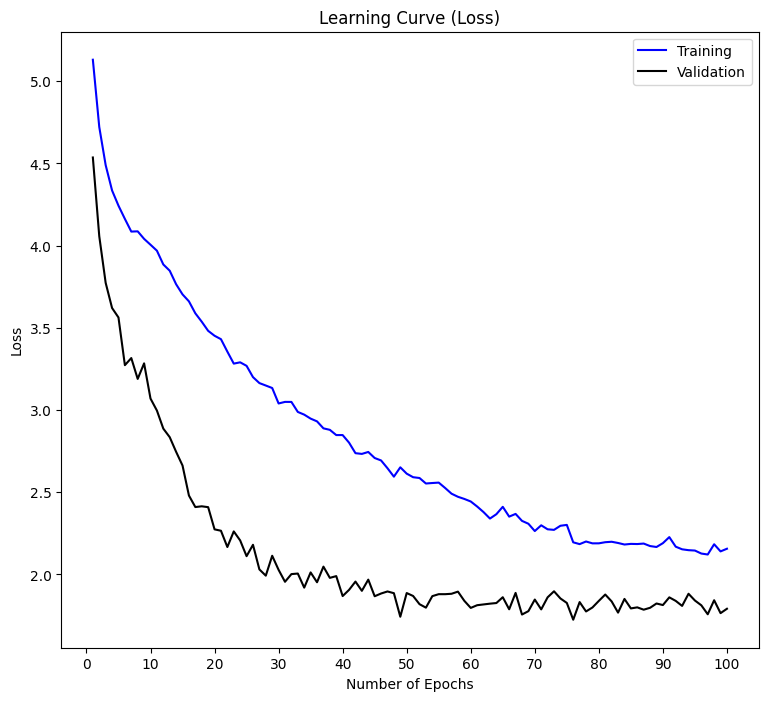

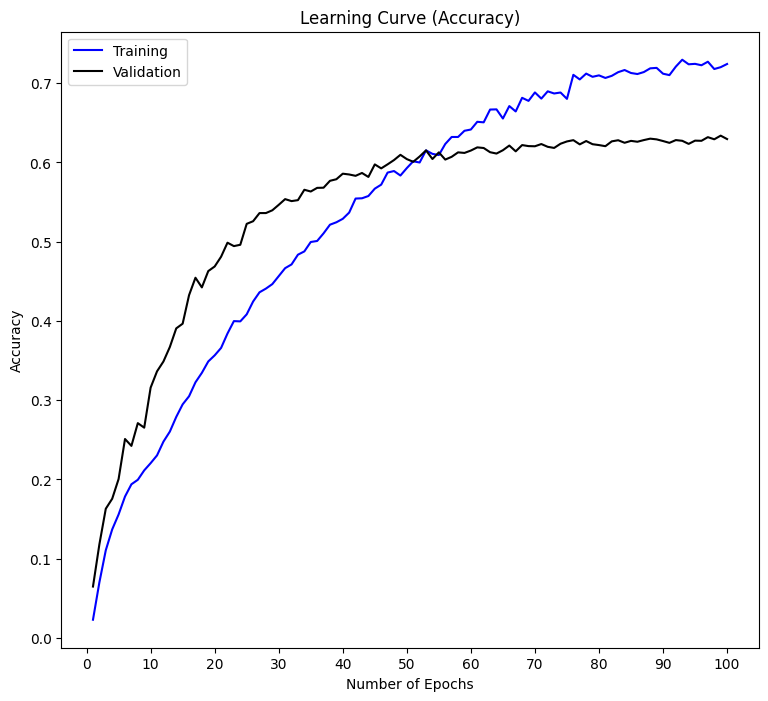

In [10]:
#------------------------------------------------------------------
# 評価

evaluate_history(history2)

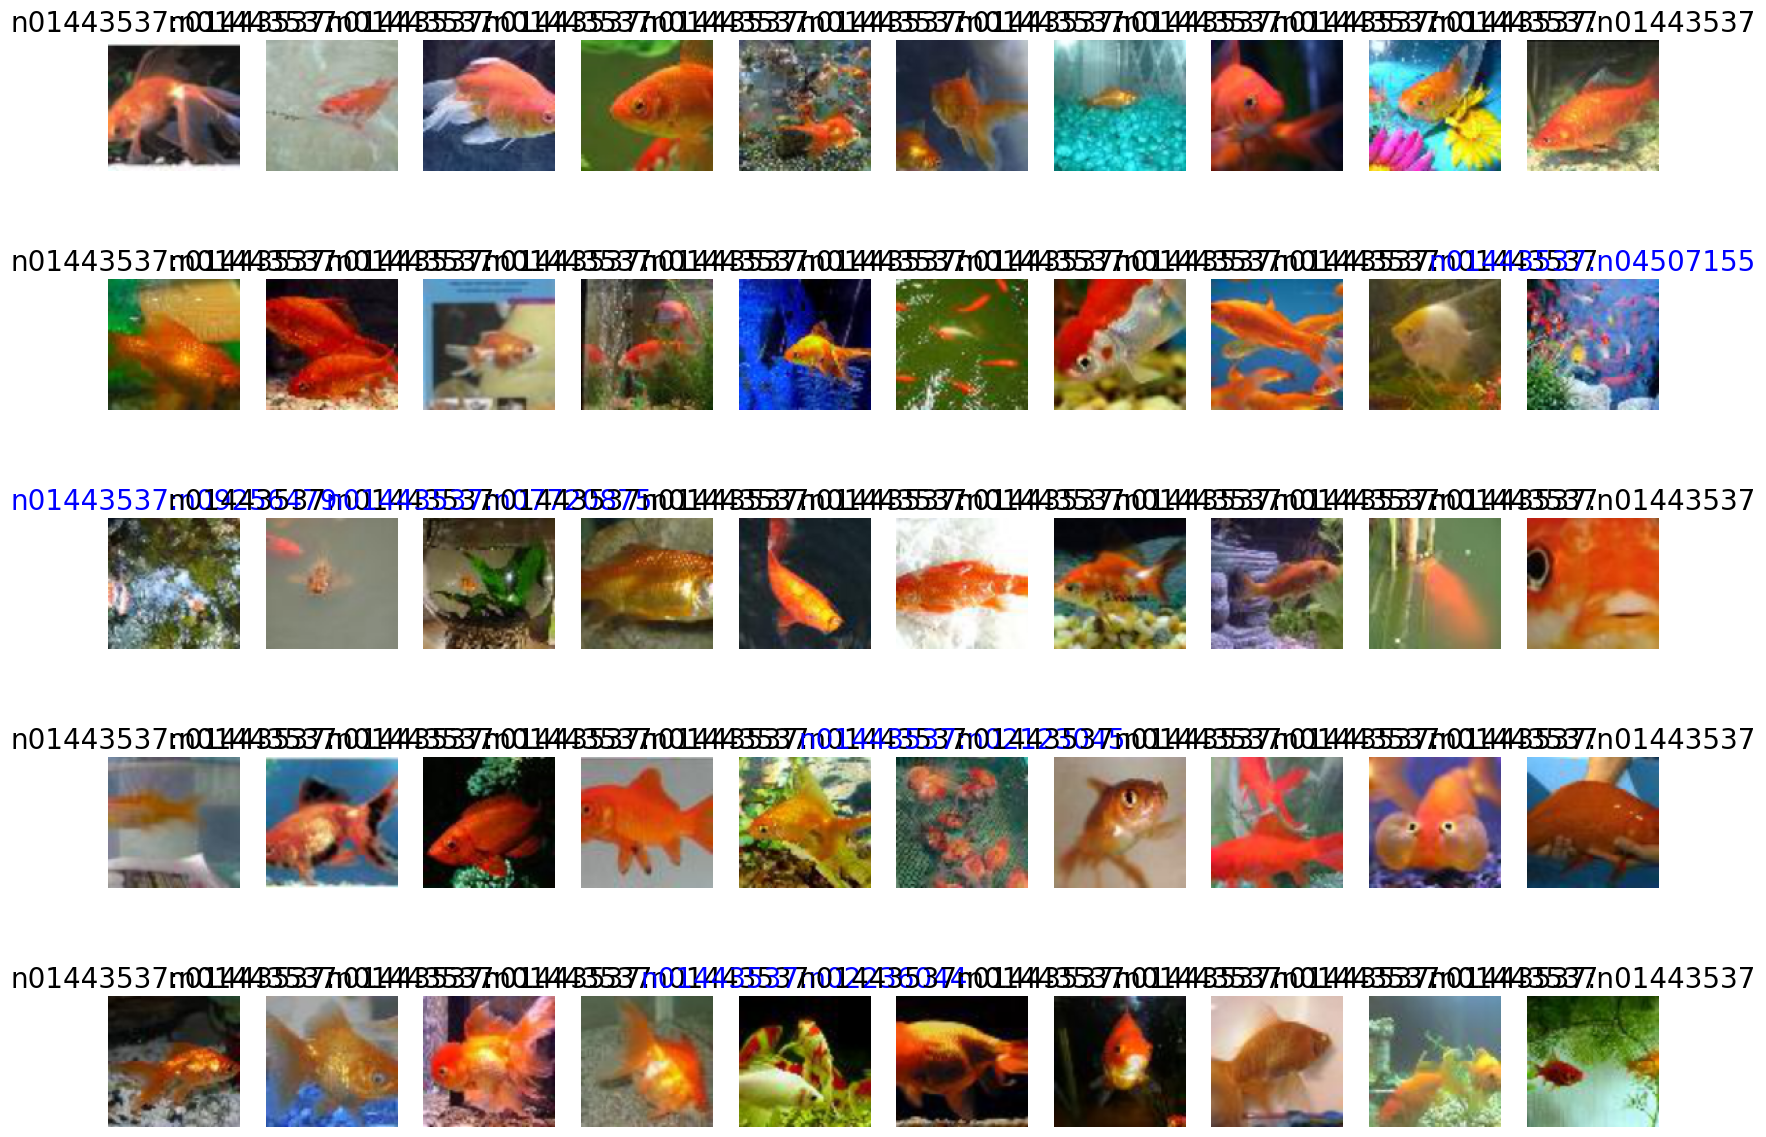

In [11]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

# -----------------------------------------------------------------------

# 最初の50個の表示
classes = train_dataset.classes
show_images_labels(val_loader, classes, net, device)